# LSTM with Word2Vec Embeddings

Sources:

How to embed with Word2Vec - https://www.kaggle.com/vladislavkisin/word2vec-in-supervised-nlp-tasks-shortcut

RNN model architecture - https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/#disqus_thread

# Pre-processing

Imports and loading dataset

In [ ]:
import pandas as pd
import nltk
import seaborn as sns
import re
import numpy as np
import warnings
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
df = pd.read_csv('train1_full.csv') 
df.head()

In [ ]:
# Here we get transform the documents into sentences for the word2vecmodel
def preprocess(df):
    df['comment_text'] = df.comment_text.str.lower()
    df['document_sentences'] = df.comment_text.str.split('.') 
    df['tokenized_sentences'] = list(map(lambda sentences: list(map(nltk.word_tokenize, sentences)), df.document_sentences))  
    df['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df.tokenized_sentences))

preprocess(df)

Split data into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(df.drop(columns='label'), df['label'], test_size=.2)

In [ ]:
def remove_items(test_list, item):
    # utility function to remove stop words
    for i in test_list:
        if(i == item):
            test_list.remove(i)
  
    return test_list

In [ ]:
def preprocess_text(sen):
    sentence = sen.lower()
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove extra spaces
    sentence = re.sub(' +', ' ', sentence)
    sentence_list = sentence.split()

    # Removing stop words
    stop_words = ['u', 'ur', 'im', 'can', 'cant', 'i', 'me', 'my', 'myself', 'we', 'go', 'our', 'ours', 'ourselves', 'you', "youre", "youve", "youll", "youd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "thatll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "shouldve", 'now', 'd', 'll', 'm', 'o', 're', 'r', 'ur', 've', 'y', 'ain', 'aren', "arent", 'couldn', "couldnt", 'didn', "didnt", 'doesn', "doesnt", 'hadn', "hadnt", 'hasn', "hasnt", 'haven', "havent", 'isn', "isnt", 'ma', 'mightn', "mightnt", 'mustn', "mustnt", 'needn', "neednt", 'shan', "shant", 'shouldn', "shouldnt", 'wasn', "wasnt", 'weren', "werent", 'won', "wont", 'wouldn', "wouldnt"]
    for stop_word in stop_words:
      if stop_word in sentence_list:
        sentence_list = remove_items(sentence_list, stop_word)

    # Join back to list
    sentence = " ".join(sentence_list)

    # Remove extra spaces
    sentence = re.sub(' +', ' ', sentence)
    return sentence.lstrip()

Get a list of all messages and labels

In [ ]:
X_train = []
sentences = list(train["comment_text"])
for sen in sentences:
    X_train.append(preprocess_text(sen))

from keras.utils.np_utils import to_categorical   
categorical_labels = to_categorical(y_train, num_classes=3) # this changes the labels to one-hot encodings!!! don't do it for your models :)

In [ ]:
X_test = []
sentences1 = list(test["comment_text"])
for sen in sentences1:
    X_test.append(preprocess_text(sen))

test_categorical_labels = to_categorical(y_test, num_classes=3)

# Tokenizing and Word2Vec Embedding

Use the Tokenizer class to convert the sentences into matrices (the X_train and X_test matrices)



In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
maxlen = 10

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_tokens = pad_sequences(X_test, padding='post', maxlen=maxlen)

Collect a vocabulary

In [ ]:
def remove_items(test_list, item):
    # remove the item for all its occurrences
    for i in test_list:
        if(i == item):
            test_list.remove(i)
  
    return test_list

In [ ]:
#Collecting a vocabulary
voc = []
# top = stopwords.words('english')
for sentence in train.tokenized_sentences:
    # if len(sentence) == 0:
    #   continue
    # else:
    #   for word in stop:
    #       sentence[0] = remove_items(sentence[0], word)
    voc.extend(sentence)

print("Number of sentences: {}.".format(len(voc)))
print("Number of rows: {}.".format(len(train)))

Use the Word2Vec embeddings, which will be used in the neural network.

In [ ]:
from gensim.models import word2vec, Word2Vec

num_features = 50
min_word_count = 1   
num_workers = 4       
context = 1        
downsampling = 1e-3   

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=6)

In [ ]:
def sentence_vectors(model, sentence):
    #Collecting all words in the text
    words = []
    if len(sentence) != 0:
      words=np.concatenate(sentence)
    #Collecting words that are known to the model
    model_voc = set(model.wv.vocab.keys()) 
    
    sent_vector = np.zeros(model.vector_size, dtype="float32")
    
    # Use a counter variable for number of words in a text
    nwords = 0
    # Sum up all words vectors that are know to the model
    for word in words:
        if word in model_voc: 
            sent_vector += model[word]
            nwords += 1.

    # Now get the average
    if nwords > 0:
        sent_vector /= nwords
    return sent_vector

train['sentence_vectors'] = list(map(lambda sen_group:
                                      sentence_vectors(W2Vmodel, sen_group),
                                      train.tokenized_sentences))

Create the embeddings matrix that will be entered into the neural network.

In [ ]:
def vectors_to_feats(df, ndim):
    index=[]
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vectors'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]
embeddings = vectors_to_feats(train, 50)
embeddings.head()
print(embeddings.shape)

In [ ]:
test['sentence_vectors'] = list(map(lambda sen_group:sentence_vectors(W2Vmodel, sen_group), test.tokenized_sentences))
X_test=vectors_to_feats(test, 50)

# Creating the Neural Network Model

Specify the model architecture

In [ ]:
maxlen = 10
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(25766, 50, weights=[embeddings], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(50)(embedding_layer)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

# Training and Evaluation

Train the model for 300 epochs

In [ ]:
history = model.fit(X_train, categorical_labels, batch_size=40, epochs=300, verbose=1, validation_split=0.20)

Epoch 1/300
516/516 [==============================] - 6s 8ms/step - loss: 0.8382 - acc: 0.5706 - val_loss: 0.8288 - val_acc: 0.5846
Epoch 2/300
516/516 [==============================] - 3s 6ms/step - loss: 0.8225 - acc: 0.5903 - val_loss: 0.8118 - val_acc: 0.5881
Epoch 3/300
516/516 [==============================] - 3s 6ms/step - loss: 0.8034 - acc: 0.5856 - val_loss: 0.8056 - val_acc: 0.5891
Epoch 4/300
516/516 [==============================] - 3s 6ms/step - loss: 0.7699 - acc: 0.5886 - val_loss: 0.7639 - val_acc: 0.6024
Epoch 5/300
516/516 [==============================] - 3s 6ms/step - loss: 0.7557 - acc: 0.5931 - val_loss: 0.7369 - val_acc: 0.6009
Epoch 6/300
516/516 [==============================] - 3s 6ms/step - loss: 0.7388 - acc: 0.5953 - val_loss: 0.7281 - val_acc: 0.6017
Epoch 7/300
516/516 [==============================] - 3s 6ms/step - loss: 0.7212 - acc: 0.6118 - val_loss: 0.7390 - val_acc: 0.5799
Epoch 8/300
516/516 [==============================] - 3s 6ms/step - 

In [ ]:
score = model.evaluate(X_test_tokens, test_categorical_labels, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
predictions = model.predict(X_test_tokens)
from sklearn.metrics import confusion_matrix
predict_labels = np.zeros((6442,))
for i in range(predictions.shape[0]):
    idx = np.argmax(predictions[i,:])
    predict_labels[i] = idx
confusion_matrix(y_test, predict_labels, normalize='true')

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
print(classification_report(y_test, predict_labels))
print(confusion_matrix(y_test, predict_labels, normalize='true'))
print("Accuracy:",metrics.accuracy_score(y_test, predict_labels))

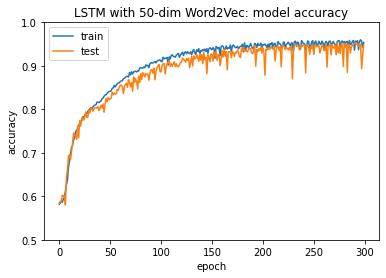

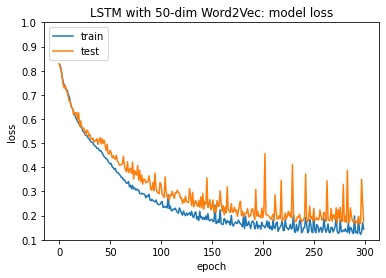

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('LSTM with 50-dim Word2Vec: model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.5,1.0))
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('LSTM with 50-dim Word2Vec: model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.1,1.0))
plt.legend(['train','test'], loc='upper left')
plt.show()